# Recovery of Heard Speech Spectrograms

## Getting the data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from algorithms import *
from utils import *
%load_ext autoreload
%autoreload 2

In [3]:
X_full = getX(1, 'MS01')
print('X found')
Y = getY(1, 'MS01')
print('Y found')
A = getA(1, 'MS01', lam=1)
print('A found')

X found
Y found
A found


In [4]:
print(X_full.shape, Y.shape, A.shape)

(2304, 5624) (64, 5624) (64, 2304)


In [5]:
np.linalg.norm(Y-A@X_full, 'fro')/np.prod(Y.shape)

0.0015720156379853663

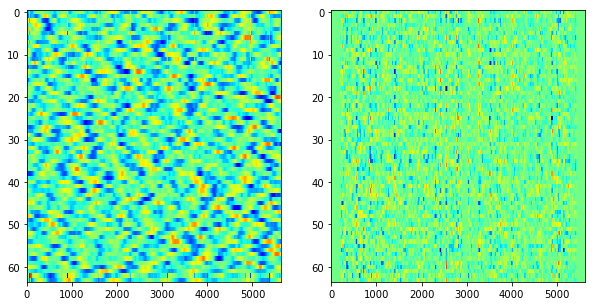

In [6]:
# %matplotlib qt
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(saturate(Y), aspect='auto',cmap='jet')
plt.subplot(122)
plt.imshow(saturate(A@X_full), aspect='auto',cmap='jet')
plt.show()

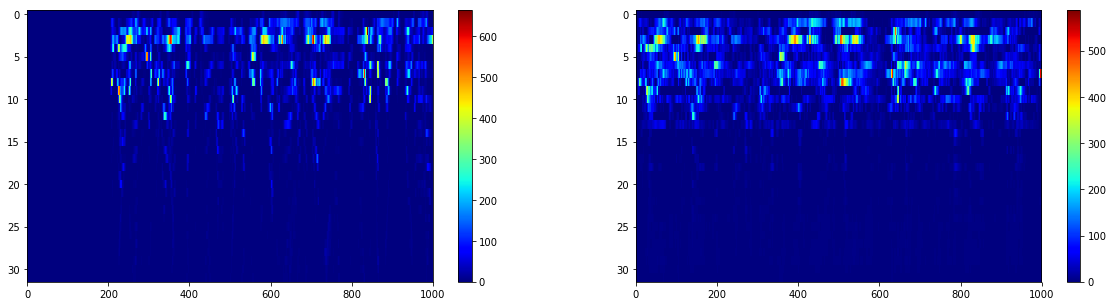

In [38]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(X_full[:32,:1000], aspect='auto',cmap='jet')
plt.colorbar()
plt.subplot(122)
rec = np.linalg.pinv(A)@Y_new
rec[rec<0] = 0
plt.imshow(rec[:32,:1000], aspect='auto',cmap='jet')
plt.colorbar()
plt.show()

## Sparse Recovery and tuning for single time step

In [8]:
X = X_full[:,200:-200]
Y_new = A@X

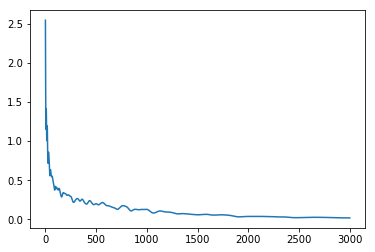

Error in objective (sparse) :  0.020052218763072244
Error in objective (dense) :  1.5508763561936685e-14
Error in x (sparse) :  1282.2385379114191
Error in x (dense) :  1582.2624265797813


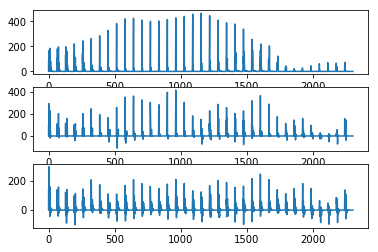

In [39]:
u = 1000
alpha = 1.2
lamda = 1e-1
t = 400
x_alm,v,err = ALM(A,Y_new[:,t],u,alpha,lamda,iters=3000)
show_result_single(A,Y_new,X,x_alm,err,t)

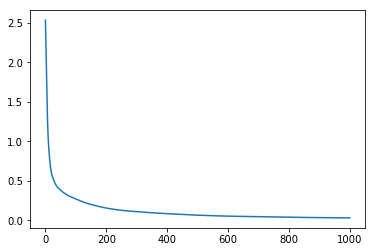

Error in objective (sparse) :  0.029977591590568817
Error in objective (dense) :  1.5508763561936685e-14
Error in x (sparse) :  1649.823847446107
Error in x (dense) :  1582.2624265797813


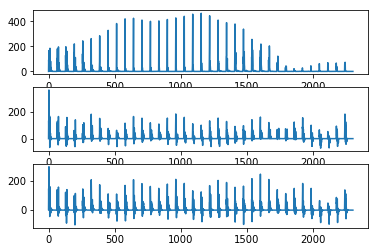

In [41]:
eig,_ = np.linalg.eig(np.dot(A.T,A))
alpha = 1/np.max(np.real(eig))
beta = 1
lamda = 1e-7
x_prox,err = acc_prox_grad(A,Y_new[:,t],alpha,beta,lamda,iters=1000)
show_result_single(A,Y_new,X,x_prox,err,t)

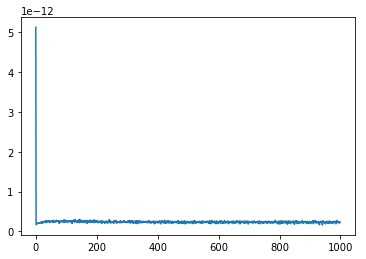

Error in objective (sparse) :  2.3215029675036194e-13
Error in objective (dense) :  1.5508763561936685e-14
Error in x (sparse) :  1281.8313736620012
Error in x (dense) :  1582.2624265797813


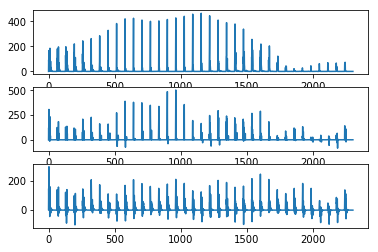

In [42]:
lr = 4e-1
x_proj,err = proj_subgrad(A,Y_new[:,t],lr,iters=1000)
show_result_single(A,Y_new,X,x_proj,err,t)

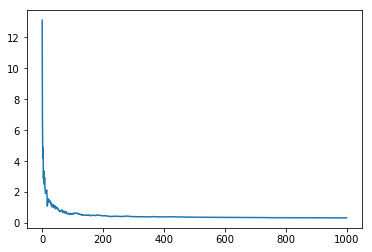

Error in objective (sparse) :  0.3339695238953274
Error in objective (dense) :  1.5508763561936685e-14
Error in x (sparse) :  2267.6928349859418
Error in x (dense) :  1582.2624265797813


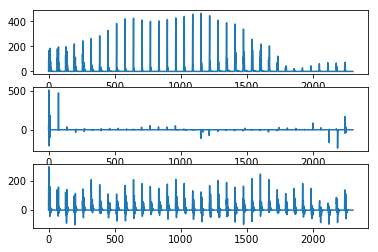

In [43]:
tau = 4000
x_fw,v,err = FrankWolfe(A,Y_new[:,t],tau,iters=1000)
show_result_single(A,Y_new,X,x_fw,err,t)

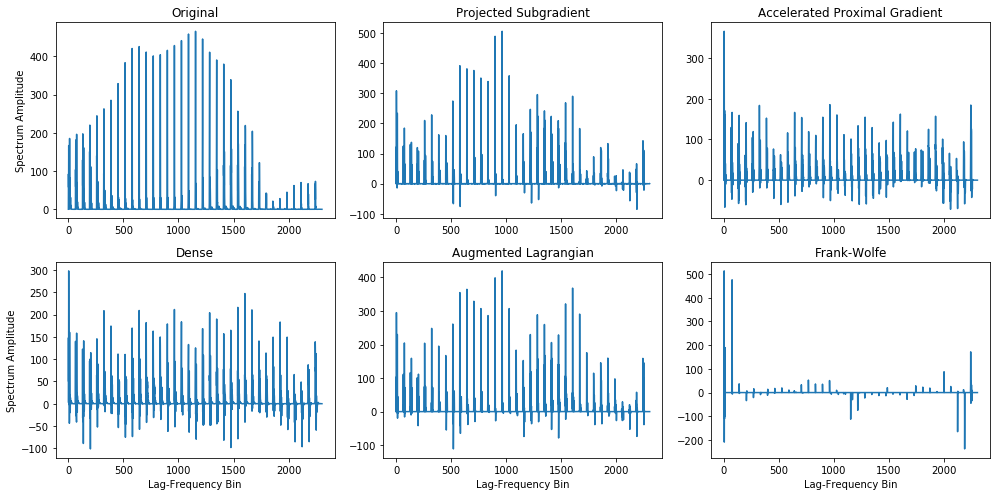

In [48]:
dense_rec = np.linalg.pinv(A)@Y_new

plt.figure(figsize=(14,7))
plt.subplot(231)
plt.title('Original')
plt.ylabel('Spectrum Amplitude')
plt.plot(X[:,t])
plt.subplot(232)
plt.title('Projected Subgradient')
plt.plot(x_proj)
plt.subplot(233)
plt.title('Accelerated Proximal Gradient')
plt.plot(x_prox)
plt.subplot(234)
plt.title('Dense')
plt.xlabel('Lag-Frequency Bin')
plt.ylabel('Spectrum Amplitude')
plt.plot(dense_rec[:,t])
plt.subplot(235)
plt.title('Augmented Lagrangian')
plt.xlabel('Lag-Frequency Bin')
plt.plot(x_alm)
plt.subplot(236)
plt.title('Frank-Wolfe')
plt.xlabel('Lag-Frequency Bin')
plt.plot(x_fw)
plt.tight_layout()

## All time steps

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0



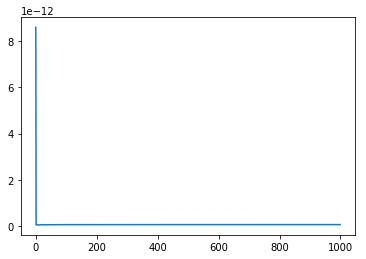

Error in objective (sparse) :  5.3267498873853517e-14
Error in objective (dense) :  7.090865028943357e-13
Error in X (sparse) :  76157.6714470609
Error in X (dense) :  78906.56910223544


In [29]:
from tqdm import tqdm_notebook as tqdm
# Using projected subgradient method
lr = 1e-1
X_rec = np.zeros_like(X)
iters = 1000
err = np.zeros(iters)
t = np.shape(Y_new)[1]

for i in tqdm(range(t)):
    X_rec[:,i],temp = proj_subgrad(A,Y_new[:,i],lr,iters=iters)
    err += np.array(temp)/t
    
show_result(A,Y_new,X,X_rec,err)

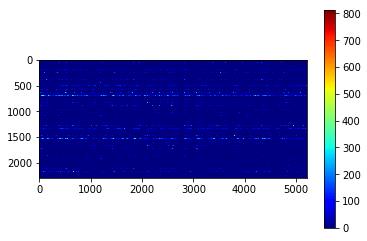

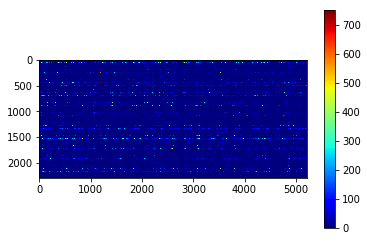

In [30]:
X_reca = X_rec.copy()
X_reca[X_reca<0] = 0
plt.imshow(X_reca,cmap='jet')
plt.colorbar()
plt.show()
plt.imshow(X,cmap='jet')
plt.colorbar()
np.save('X_rec.npy',X_reca)

In [58]:
# Load result from saved file
X_rec = np.load('X_rec.npy')
X_rec.shape

Xdense = np.linalg.pinv(A) @ Y_new
Xdense[Xdense<0] = 0

Rec Fro Loss 74401.92850757968
Dense Fro Loss 74511.62222131944


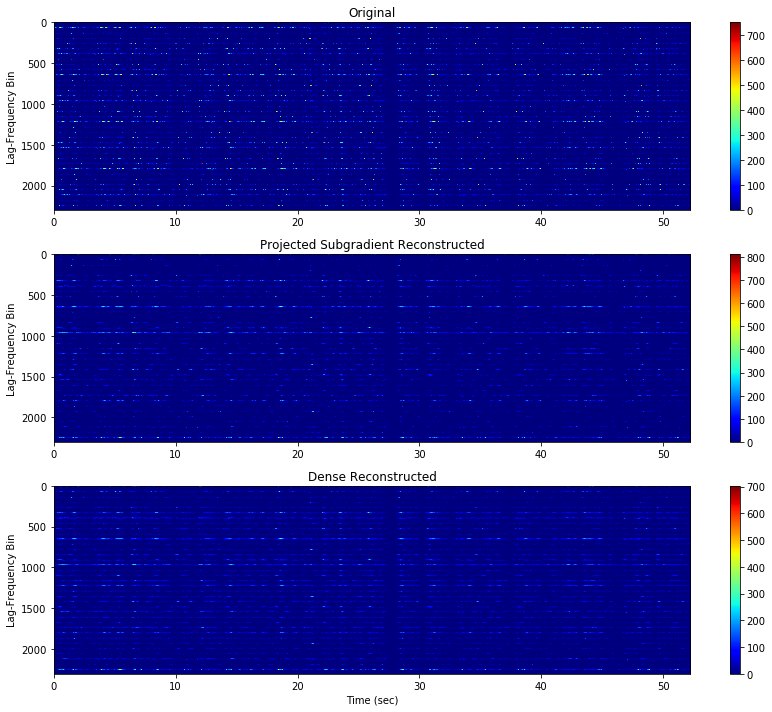

In [103]:
plt.figure(figsize=(12,10))
plt.subplot(311)
plt.title('Original')
plt.imshow(X,cmap='jet', aspect='auto')
plt.xticks(ticks=np.arange(0,5001,1000), labels=np.arange(0,51,10))
plt.ylabel('Lag-Frequency Bin')
plt.colorbar()
plt.subplot(313)
plt.title('Dense Reconstructed')
plt.imshow(Xdense, cmap='jet', aspect='auto')
plt.xticks(ticks=np.arange(0,5001,1000), labels=np.arange(0,51,10))
plt.xlabel('Time (sec)')
plt.ylabel('Lag-Frequency Bin')
plt.colorbar()
plt.subplot(312)
plt.title('Projected Subgradient Reconstructed')
plt.imshow(X_rec, cmap='jet', aspect='auto')
plt.xticks(ticks=np.arange(0,5001,1000), labels=np.arange(0,51,10))
plt.ylabel('Lag-Frequency Bin')
plt.colorbar()
plt.tight_layout()

print('Rec Fro Loss', np.linalg.norm(X-X_rec, 'fro'))
print('Dense Fro Loss', np.linalg.norm(X-Xdense, 'fro'))

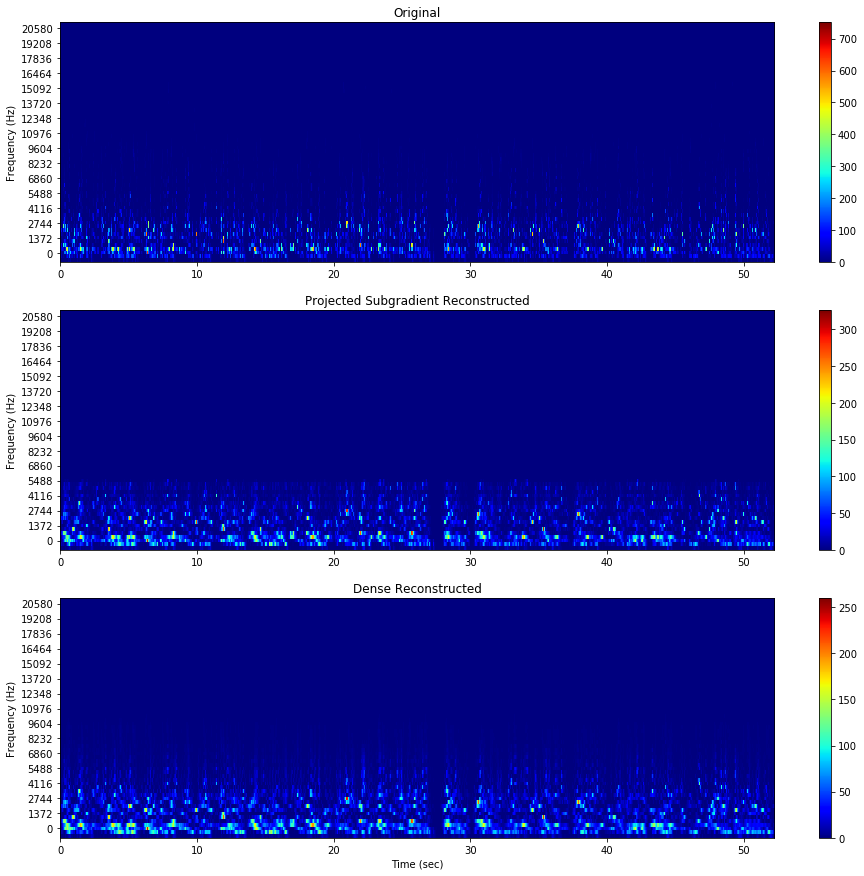

Rec Fro Loss 9748.021451328605
Dense Fro Loss 10880.22916634782


In [98]:
X0rec = delagData(X_rec, mode='mean')
X0 = delagData(X)
X0dense = np.linalg.pinv(A) @ Y_new
X0dense = delagData(X0dense, mode='mean')
X0dense[X0dense<0] = 0

nFreqs = 64
spc = 4
plt.figure(figsize=(16,15))
plt.subplot(311)
plt.title('Original')
plt.imshow(np.flipud(X0[:nFreqs,:]),cmap='jet', aspect='auto')
plt.xticks(ticks=np.arange(0,5001,1000), labels=np.arange(0,51,10))
plt.yticks(ticks=np.flip(np.arange(0,nFreqs,spc))+1,
           labels=np.arange(0,22000//64*nFreqs,22000//64*spc))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.subplot(312)
plt.title('Projected Subgradient Reconstructed')
plt.imshow(np.flipud(X0rec[:nFreqs,:]), cmap='jet', aspect='auto')
plt.xticks(ticks=np.arange(0,5001,1000), labels=np.arange(0,51,10))
plt.yticks(ticks=np.flip(np.arange(0,nFreqs,spc))+1,
           labels=np.arange(0,22000//64*nFreqs,22000//64*spc))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.subplot(313)
plt.title('Dense Reconstructed')
plt.imshow(np.flipud(X0dense[:nFreqs,:]), cmap='jet', aspect='auto')
plt.xticks(ticks=np.arange(0,5001,1000), labels=np.arange(0,51,10))
plt.yticks(ticks=np.flip(np.arange(0,nFreqs,spc))+1,
           labels=np.arange(0,22000//64*nFreqs,22000//64*spc))
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.show()

print('Rec Fro Loss', np.linalg.norm(X0-X0rec, 'fro'))
print('Dense Fro Loss', np.linalg.norm(X0-X0dense, 'fro'))

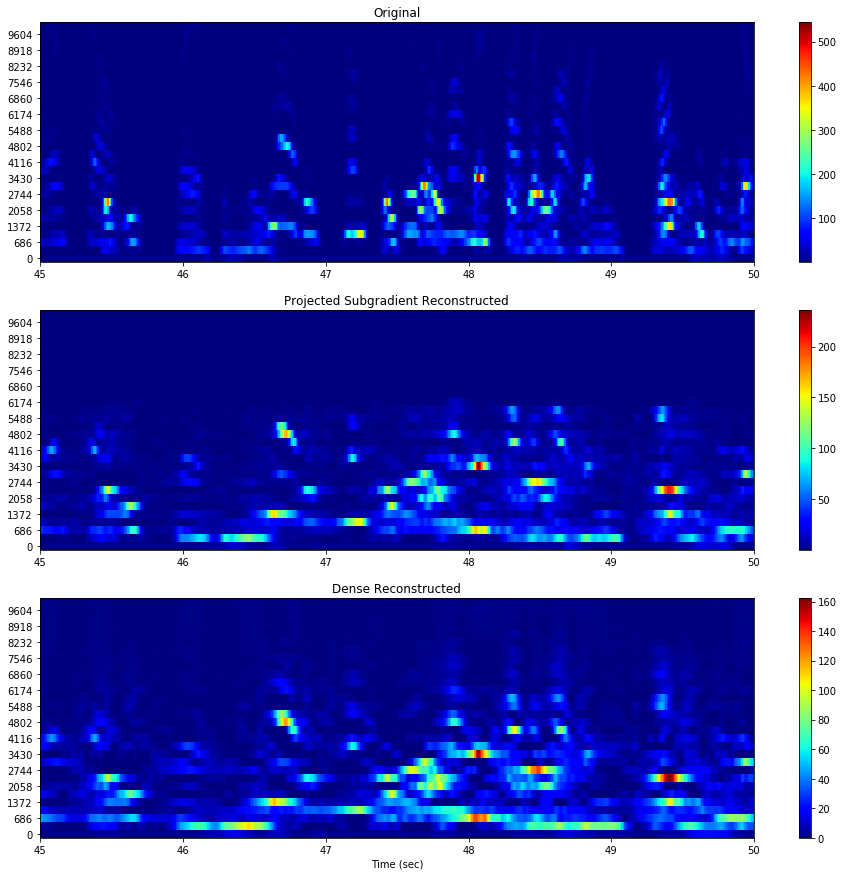

In [102]:
nFreqs = 30
spc=2
tStart = 4500
tLen = 500
plt.figure(figsize=(16,15))
plt.subplot(311)
plt.title('Original')
plt.imshow(np.flipud(X0[:nFreqs,tStart:tStart+tLen]),cmap='jet', aspect='auto')
plt.xticks(ticks=np.arange(0,501,100), labels=np.arange(tStart//100,(tStart+tLen+100)//100,1))
plt.yticks(ticks=np.flip(np.arange(0,nFreqs,spc))+1,
           labels=np.arange(0,22000//64*nFreqs,22000//64*spc))
plt.colorbar()
plt.subplot(312)
plt.title('Projected Subgradient Reconstructed')
plt.imshow(np.flipud(X0rec[:nFreqs,tStart:tStart+tLen]), cmap='jet', aspect='auto')
plt.xticks(ticks=np.arange(0,501,100), labels=np.arange(tStart//100,(tStart+tLen+100)//100,1))
plt.yticks(ticks=np.flip(np.arange(0,nFreqs,spc))+1,
           labels=np.arange(0,22000//64*nFreqs,22000//64*spc))
plt.colorbar()
plt.subplot(313)
plt.title('Dense Reconstructed')
plt.imshow(np.flipud(X0dense[:nFreqs,tStart:tStart+tLen]), cmap='jet', aspect='auto')
plt.xticks(ticks=np.arange(0,501,100), labels=np.arange(tStart//100,(tStart+tLen+100)//100,1))
plt.yticks(ticks=np.flip(np.arange(0,nFreqs,spc))+1,
           labels=np.arange(0,22000//64*nFreqs,22000//64*spc))
plt.xlabel('Time (sec)')
plt.colorbar()
plt.show()

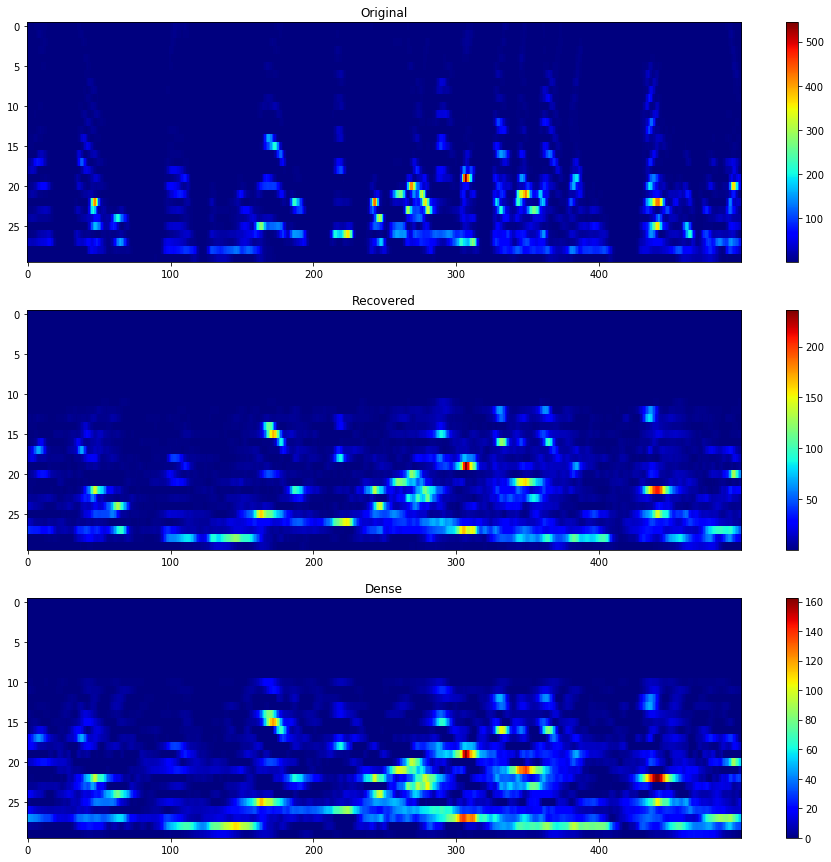

Rec Fro Loss 9748.021451328605
Dense Fro Loss 10893.478123117846


In [80]:
X0dense_0 = X0dense.copy()
X0dense_0[20:,:] = 0

nFreqs = 30
tStart = 4500
tLen = 500
plt.figure(figsize=(16,15))
plt.subplot(311)
plt.title('Original')
plt.imshow(np.flipud(X0[:nFreqs,tStart:tStart+tLen]),cmap='jet', aspect='auto')
plt.colorbar()
plt.subplot(312)
plt.title('Projected Subgradient Reconstructed')
plt.imshow(np.flipud(X0rec[:nFreqs,tStart:tStart+tLen]), cmap='jet', aspect='auto')
plt.colorbar()
plt.subplot(313)
plt.title('Dense Reconstructed')
plt.imshow(np.flipud(X0dense_0[:nFreqs,tStart:tStart+tLen]), cmap='jet', aspect='auto')
plt.colorbar()
plt.show()

print('Rec Fro Loss', np.linalg.norm(X0-X0rec, 'fro'))
print('Dense Fro Loss', np.linalg.norm(X0-X0dense_0, 'fro'))